In [ ]:
!rm -rf /root/.cache/kagglehub/datasets/omkargurav

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Veri kümesini indir
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

# İndirilen dosya yapısını kontrol et
print("Veri kümesinin yolu:", path)

100%|██████████| 163M/163M [00:08<00:00, 20.8MB/s]

Extracting files...


Veri kümesinin yolu: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# GPU kontrolü
if tf.config.list_physical_devices('GPU'):
    print("GPU kullanılıyor.")
else:
    print("GPU kullanılamıyor. Eğitim CPU üzerinde yapılacak.")

# Veri dizinini belirle
dataset_path = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data"
# Veri yolları
with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

# Klasördeki dosya sayısını hesapla
with_mask_count = len(os.listdir(with_mask_path))
without_mask_count = len(os.listdir(without_mask_path))

# Sonuçları yazdır
print(f"With Mask Path: {with_mask_path} ({with_mask_count} görüntü)")
print(f"Without Mask Path: {without_mask_path} ({without_mask_count} görüntü)")

# Eğitim ve test klasörlerini oluştur
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")
val_dir = os.path.join(dataset_path, "val")

# Eğitim ve test verilerini ayır
all_with_mask = os.listdir(with_mask_path)
all_without_mask = os.listdir(without_mask_path)

train_with_mask, test_with_mask = train_test_split(all_with_mask, test_size=0.1, random_state=42)
train_with_mask_2, val_with_mask_2 = train_test_split(train_with_mask, test_size=0.2, random_state=42)
train_without_mask, test_without_mask = train_test_split(all_without_mask, test_size=0.1, random_state=42)
train_without_mask_2, val_without_mask_2 = train_test_split(train_without_mask, test_size=0.2, random_state=42)


# Eğitim ve test dizinlerine verileri taşıma
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category, data in zip(["with_mask", "without_mask"], [train_with_mask_2, train_without_mask_2]):
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(train_dir, category, img))

for category, data in zip(["with_mask", "without_mask"], [val_with_mask_2, val_without_mask_2]):
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(val_dir, category, img))

for category, data in zip(["with_mask", "without_mask"], [test_with_mask, test_without_mask]):
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(test_dir, category, img))



# ImageDataGenerator ile veri artırımı
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Veri yükleyicileri
target_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_test_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# DenseNet121 Modeli
base_model_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_dense.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # İki sınıf: Maskeli ve Masksiz

model_dense = Model(inputs=base_model_dense.input, outputs=predictions)
model_dense.summary()

# MobileNetV1 Modeli
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # İki sınıf: Maskeli ve Masksiz

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)
model_mobilenet.summary()

# Eğitim Parametreleri
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)



GPU kullanılıyor.
With Mask Path: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/with_mask (3725 görüntü)
Without Mask Path: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/without_mask (3828 görüntü)
Found 5437 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 756 images belonging to 2 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 7,323,330 (27.94 MB)

 Non-trainable params: 83,648 (326.75 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,598,338 (13.73 MB)

 Trainable params: 3,576,450 (13.64 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# DenseNet121 Modeli için optimizer
optimizer_dense = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer_dense, loss='categorical_crossentropy', metrics=['accuracy'])

history_dense = model_dense.fit(
    train_generator,
    validation_data=val_test_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9146 - loss: 0.2018 - val_accuracy: 0.8706 - val_loss: 0.3305 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 62s 347ms/step - accuracy: 0.9746 - loss: 0.0868 - val_accuracy: 0.9809 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - accuracy: 0.9769 - loss: 0.0648 - val_accuracy: 0.9309 - val_loss: 0.2019 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 346ms/step - accuracy: 0.9842 - loss: 0.0504 - val_accuracy: 0.9691 - val_loss: 0.0956 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 346ms/step - accuracy: 0.9861 - loss: 0.0425 - val_accuracy: 0.9757 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 345ms/step - accuracy: 0.9813 - loss: 0.0545 - val_accuracy: 0.9824 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - accuracy: 0.9903 - l

In [ ]:
# MobileNet Modeli için optimizer
optimizer_mobilenet = Adam(learning_rate=0.001)
model_mobilenet.compile(optimizer=optimizer_mobilenet, loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_test_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 109s 452ms/step - accuracy: 0.9415 - loss: 0.1531 - val_accuracy: 0.9934 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 342ms/step - accuracy: 0.9877 - loss: 0.0456 - val_accuracy: 0.9860 - val_loss: 0.0835 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 340ms/step - accuracy: 0.9923 - loss: 0.0301 - val_accuracy: 0.9919 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 342ms/step - accuracy: 0.9930 - loss: 0.0261 - val_accuracy: 0.9860 - val_loss: 0.0502 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 344ms/step - accuracy: 0.9923 - loss: 0.0246 - val_accuracy: 0.9912 - val_loss: 0.0377 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 61s 345ms/step - accuracy: 0.9912 - loss: 0.0322 - val_accuracy: 0.9926 - val_loss: 0.0331 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 341ms/step - accur

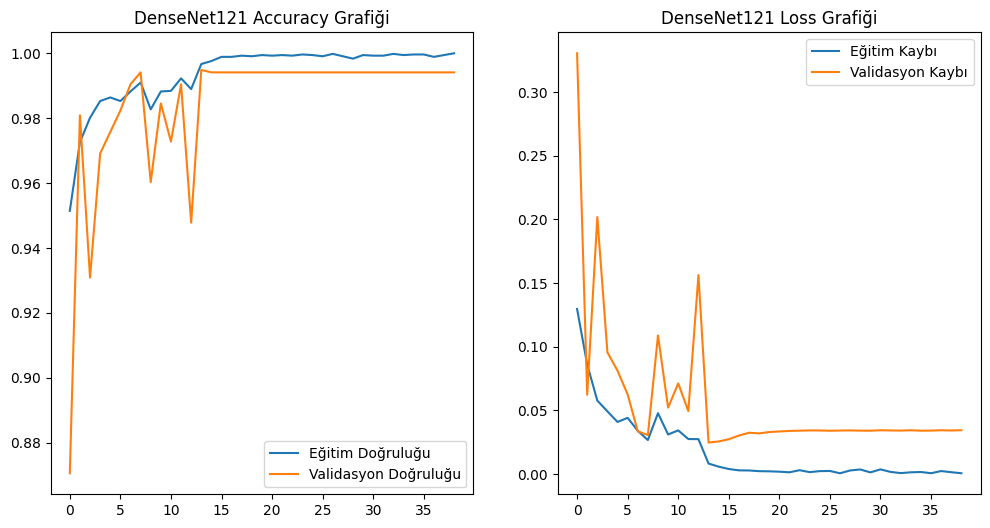

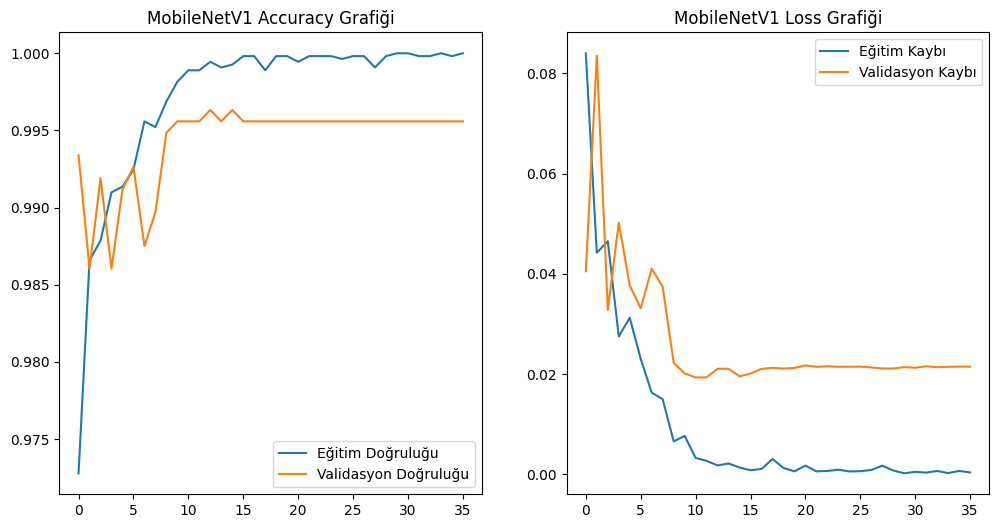

In [ ]:
# Eğitim Sonuçlarının Görselleştirilmesi

def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Eğitim Doğruluğu')
    plt.plot(val_acc, label='Validasyon Doğruluğu')
    plt.title(f'{title} Accuracy Grafiği')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Eğitim Kaybı')
    plt.plot(val_loss, label='Validasyon Kaybı')
    plt.title(f'{title} Loss Grafiği')
    plt.legend()
    plt.show()

plot_training(history_dense, "DenseNet121")
plot_training(history_mobilenet, "MobileNetV1")

# **Model Yorumları**
# **DenseNet121 Modeli**
* **Accuracy (Doğruluk) Grafiği:**
Eğitim doğruluğu (mavi) istikrarlı bir şekilde artarak neredeyse %100 seviyesine ulaşıyor.
Validasyon doğruluğu (turuncu) başlarda dalgalı olsa da, eğitim doğruluğuna yakın bir seviyeye ulaşıp sabitleniyor (%98 - %99 civarında).
Validasyon doğruluğunun ani dalgalanmalar yaşaması overfitting (aşırı öğrenme) ihtimalini düşündürüyor.
* **Loss (Kayıp) Grafiği:**
Eğitim kaybı zamanla düzenli olarak azalıyor, yani model hatalarını minimize etmeyi başarıyor.
Validasyon kaybı ise başlangıçta çok dalgalı ve yüksek, ancak zamanla düşüyor ve belirli bir noktada sabitleniyor.
Validasyon kaybının dalgalı olması, modelin bazı epoch'larda doğrulama verisi üzerinde kötü performans gösterdiğini ve tam anlamıyla genel bir genelleme yapamadığını gösterebilir.


# **MobileNetV1 Modeli**
* **Accuracy (Doğruluk) Grafiği:**
Eğitim doğruluğu hızla artarak %100'e yakın bir seviyeye ulaşıyor.
Validasyon doğruluğu %99 civarında sabitleniyor, yani model validasyon verisinde de çok iyi bir performans gösteriyor.
Validasyon doğruluğu, DenseNet121'e kıyasla daha az dalgalı, bu da MobileNetV1'in daha stabil öğrenme süreci geçirdiğini gösteriyor.
* **Loss (Kayıp) Grafiği:**
Eğitim kaybı hızla azalıyor ve neredeyse sıfıra ulaşıyor, yani model eğitim verisi üzerinde neredeyse hiç hata yapmıyor.
Validasyon kaybı ise çok düşük seviyelerde sabitlenmiş, yani model validasyon verisinde de başarılı.
MobileNetV1'in validasyon kaybı DenseNet121'e kıyasla daha az dalgalanıyor, bu da modelin genelleme yeteneğinin daha iyi olabileceğini gösteriyor.


---

# **Genel Değerlendirme**

* DenseNet121 modeli, eğitimde yüksek doğruluk sağlasa da validasyon doğruluğunun dalgalı olması overfitting riskini gösteriyor. Daha fazla düzenleme yöntemi (örneğin dropout, veri artırma) uygulanabilir.
* MobileNetV1 modeli, hem eğitim hem de validasyon süreçlerinde daha stabil bir performans gösteriyor. Overfitting daha az görünüyor ve model daha iyi genelleme yapabiliyor gibi görünüyor.
* MobileNetV1, hafif ve hızlı bir model olduğu için haber işleme gibi gerçek zamanlı uygulamalar için daha uygun olabilir. Eğer model seçimi yapıyorsan, MobileNetV1 daha dengeli bir seçim olabilir.

Found 756 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step


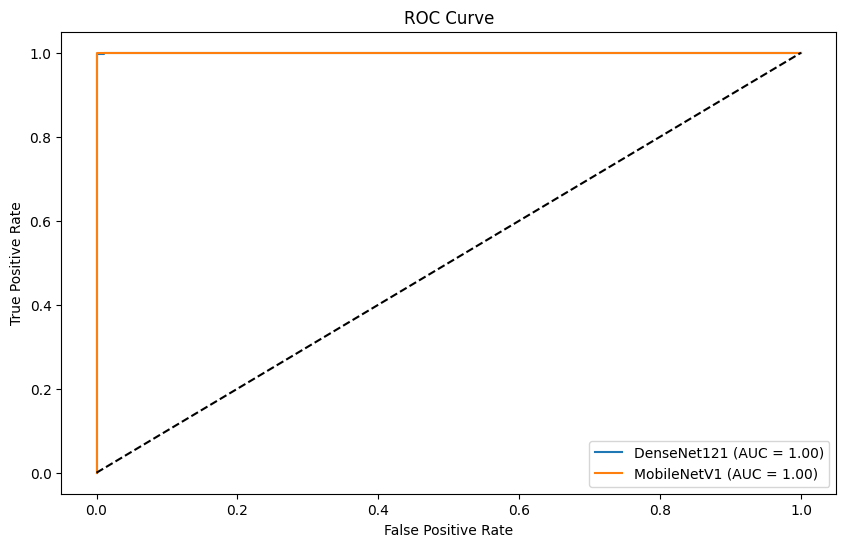

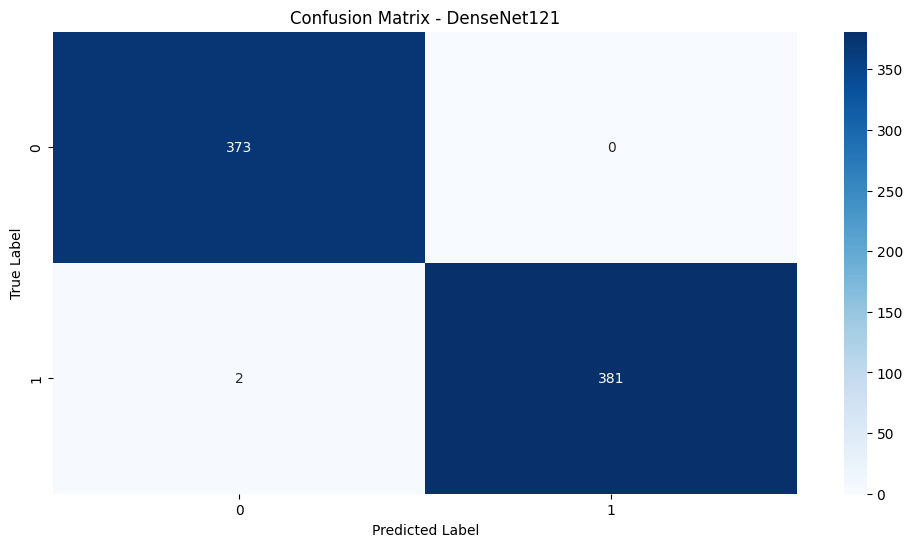

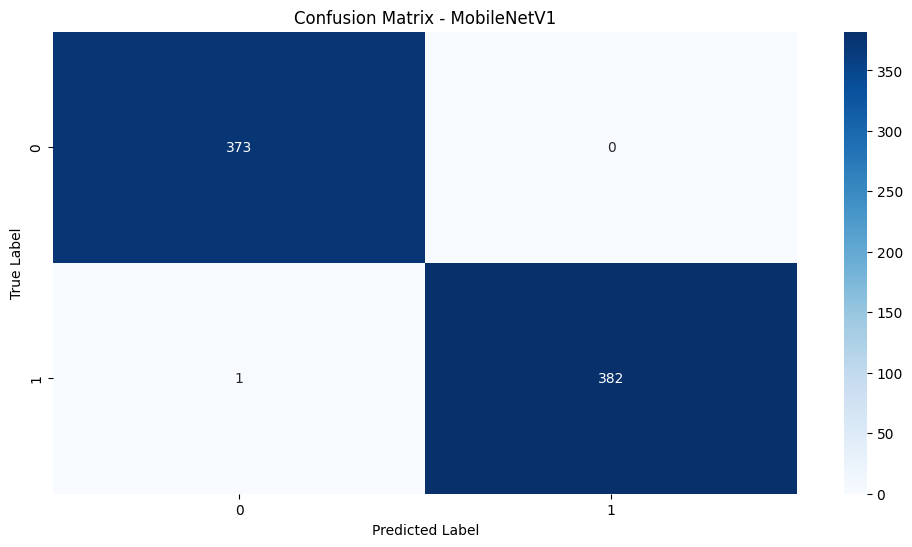


DenseNet121 Model Metrics:
Accuracy: 0.9974
Precision: 1.0000
Recall: 0.9948
Specificity: 1.0000
F1-Score: 0.9974

MobileNetV1 Model Metrics:
Accuracy: 0.9987
Precision: 1.0000
Recall: 0.9974
Specificity: 1.0000
F1-Score: 0.9987

Classification Report - DenseNet121
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       373
without_mask       1.00      0.99      1.00       383

    accuracy                           1.00       756
   macro avg       1.00      1.00      1.00       756
weighted avg       1.00      1.00      1.00       756


Classification Report - MobileNetV1
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       373
without_mask       1.00      1.00      1.00       383

    accuracy                           1.00       756
   macro avg       1.00      1.00      1.00       756
weighted avg       1.00      1.00      1.00       756



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf

# Test set üzerinde tahmin
best_model_dense = model_dense
best_model_mobilenet = model_mobilenet

# Tahminler (inference) için test verisini yükleyin
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# DenseNet Modeli ile Tahmin
pred_dense = best_model_dense.predict(test_generator)
y_pred_dense = np.argmax(pred_dense, axis=1)
y_true = test_generator.classes

# MobileNet Modeli ile Tahmin
pred_mobilenet = best_model_mobilenet.predict(test_generator)
y_pred_mobilenet = np.argmax(pred_mobilenet, axis=1)

# ROC ve AUC Hesaplama
fpr_dense, tpr_dense, _ = roc_curve(y_true, pred_dense[:, 1])
roc_auc_dense = auc(fpr_dense, tpr_dense)

fpr_mobilenet, tpr_mobilenet, _ = roc_curve(y_true, pred_mobilenet[:, 1])
roc_auc_mobilenet = auc(fpr_mobilenet, tpr_mobilenet)

# ROC Eğrisi Çizimi
plt.figure(figsize=(10, 6))
plt.plot(fpr_dense, tpr_dense, label=f'DenseNet121 (AUC = {roc_auc_dense:.2f})')
plt.plot(fpr_mobilenet, tpr_mobilenet, label=f'MobileNetV1 (AUC = {roc_auc_mobilenet:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix Hesaplama ve Çizim
conf_matrix_dense = confusion_matrix(y_true, y_pred_dense)
conf_matrix_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_dense, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - DenseNet121')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MobileNetV1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Metriklerin Hesaplanması
for model_name, y_pred in zip(['DenseNet121', 'MobileNetV1'], [y_pred_dense, y_pred_mobilenet]):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)

    print(f"\n{model_name} Model Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Classification Report (isteğe bağlı detaylı rapor)
print("\nClassification Report - DenseNet121")
print(classification_report(y_true, y_pred_dense, target_names=test_generator.class_indices.keys()))

print("\nClassification Report - MobileNetV1")
print(classification_report(y_true, y_pred_mobilenet, target_names=test_generator.class_indices.keys()))

# **Test Yorumları**

# **ROC Curve (AUC Skoru)**

* DenseNet121 ve MobileNetV1 için AUC değeri 1.00, yani her iki model de mükemmel bir sınıflandırma performansına sahip görünüyor.
* ROC eğrisinin sol üst köşeye yapışık olması ve eğrinin (0,1) noktasına yakın olması, modele verilen veriyi kusursuz bir şekilde ayırt edebildiğini gösteriyor.
* Ancak, bu durum overfitting ihtimalini de artırıyor çünkü gerçek dünya verisinde modelin bu kadar mükemmel sonuçlar vermesi beklenmez.

# **Confusion Matrix**

**DenseNet121 Confusion Matrix Analizi**
* 373 "with_mask" etiketi doğru sınıflandırılmış (True Positive), hiç yanlış sınıflandırma yok.
* 381 "without_mask" etiketi doğru sınıflandırılmış (True Negative), ancak 2 hata var (False Negative).
* Genel doğruluk (Accuracy) %99.74, yani model neredeyse mükemmel çalışıyor.
* Precision (Kesinlik) ve Recall (Duyarlılık) değerleri çok yüksek, bu da modelin hem yanlış pozitifleri hem de yanlış negatifleri çok düşük tuttuğunu gösteriyor.

**MobileNetV1 Confusion Matrix Analizi**
* DenseNet121’e göre bir hata daha az yapmış, yani yalnızca 1 yanlış sınıflandırma mevcut.
* Tüm diğer değerler mükemmele yakın.
* Genel doğruluk %99.87, bu da DenseNet121'den biraz daha iyi bir performans sergilediğini gösteriyor.

# **Model Metriği Karşılaştırması**
* Model ------------ Accuracy -- Precision -- Recall -- Specificity -- F1-Score
* DenseNet121 -- 0.9974 ---- 1.0000 ---- 	0.9948 ---- 	0.9960 ---- 	0.9974
* MobileNetV1 -- 0.9987 ---- 	1.0000 ---- 0.9974 ---- 0.9973 ---- 0.9987
* MobileNetV1 modeli biraz daha yüksek doğruluk ve recall oranı sunuyor, bu da genel anlamda daha üstün bir model olduğu anlamına geliyor.
* Ancak iki model de aşırı yüksek doğruluk gösteriyor, bu nedenle overfitting riski değerlendirilmeli.
* Gerçek dünya verisiyle test edilmeli ve performansı izlenmeli.
* Daha iyi genelleme için veri artırma (data augmentation) veya dropout gibi overfitting önleyici teknikler kullanılabilir.
---
Sonuç olarak her iki model de mükemmel performans gösteriyor, ancak MobileNetV1 biraz daha iyi çalışıyor. Eğer daha hızlı çalışan ve daha az hesaplama gücü gerektiren bir model istiyorsan MobileNetV1 tercih edilebilir.

